# Imports & Variables

In [1]:
## check if we are running the notebook in Colab or locally
from termcolor import colored

try:
    from google.colab import drive
    COLAB = True
    print('Running the notebook on',colored('Colab','yellow'))
except:
    COLAB = False
    print('Running the notebook on',colored('your machine','blue'))

Running the notebook on Colab


In [2]:
#utilities
import os 
import pickle
from tqdm.notebook import tqdm_notebook

# Canonical import
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

#deep
import tensorflow as tf
if COLAB:
  !pip install --quiet transformers
from transformers import TFAutoModel, AutoTokenizer


     |████████████████████████████████| 3.5 MB 6.8 MB/s 
     |████████████████████████████████| 596 kB 62.2 MB/s 
     |████████████████████████████████| 6.8 MB 83.7 MB/s 
     |████████████████████████████████| 895 kB 47.3 MB/s 
     |████████████████████████████████| 67 kB 6.6 MB/s 


In [3]:
## Utilities variables

#Sample mode 
SAMPLE_MODE = 3000

#Max len of essay
SEQ_LEN = 1024

#Train, val, test split proportion
VAL_SPLIT = 0.8
TEST_SPLIT = 0.9

#Batch size
BATCH_SIZE = 64

#if set to true, will tokenize the dataset and train the model, otherwise loaded
LOAD_TOKENS = True
LOAD_MODEL = False

In [4]:
## if running in colab, mount drive

if COLAB:
    drive.mount('/content/drive')
    PATH_RAW_DATA='/content/drive/MyDrive/feedback-prize/raw_data/'
else:
    PATH_RAW_DATA='/Users/arthurcollard/code/arthurcol/feedback_prize/raw_data/'

Mounted at /content/drive


# Load data

## Load original train.csv dataset

In [5]:
#load train.csv 
if COLAB:
    df = pd.read_csv(PATH_RAW_DATA+'train.csv',nrows=SAMPLE_MODE)
else:
    df = pd.read_csv(PATH_RAW_DATA+'train.csv',nrows=SAMPLE_MODE)

## Create a second dataset where an element = an essay
The objective here is to have a dataset where essays are grouped and where the labels match a word using BIO notation.

In [6]:
## Def a function for labelling discourses per word

def labelizer(label,len_,flag):
    """Repeat the label according to the length of the sentence. Makes use of B/I notation according to the position of the word within the sentence and the sentence within the essay.

    Args:
        label (str): NER label of the sentence.
        len_ (int): Length of the sentence (n° of words).
        flag (int): 1 if the sentence follows a sentence with the same label. 0 otherwise.

    Returns:
        str: Returns a string of length (n° of words) len_ with B/I-label repeated len_ times.
    """
    if flag==0:
        label_first = f'B-{label} '
    else:
        label_first = f'I-{label} '
        
    return (label_first + f'I-{label} '*(len_-1)).strip()

In [ ]:
## Creating features for labeling needs : 

    #Flag if the discourse is the same as the previous one
df['previous_discourse_flag']=np.where(df['discourse_type'].shift(1)==df['discourse_type'],1,0)

    #Get length of predictionstring
df['predictionstring_len'] = df['predictionstring'].apply(lambda txt:len(txt.split()))

    # Remove spaces in labels
df['discourse_type']=df['discourse_type'].str.replace('Concluding Statement','Concluding_Statement')

In [ ]:
# vectorize labelizer func and apply to our df 
labelizer_vect = np.vectorize(labelizer)
df['label']=labelizer_vect(df['discourse_type'],df['predictionstring_len'],df['previous_discourse_flag'])
df.head(1)

,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring,previous_discourse_flag,predictionstring_len,label
0,423A1CA112E2,1.622628e+12,8.0,229.0,Modern humans today are always on their phone....,Lead,Lead 1,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...,0,44,B-Lead I-Lead I-Lead I-Lead I-Lead I-Lead I-Le...


In [ ]:
## Groupby ID to get predictionstrings and labels as a unique string

df_essays = df.groupby('id').agg({'predictionstring':' '.join,'label':' '.join})

## Transform into lists

df_essays['label'] = df_essays['label'].apply(lambda txt : txt.split())
df_essays['predictionstring'] = df_essays['predictionstring'].apply(lambda txt : txt.split())

#remove utilities columns created in the original df
df.drop(['previous_discourse_flag','predictionstring_len','label'],axis=1,inplace=True)

display(df.head(3),df_essays.head(3))

,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring
0,423A1CA112E2,1.622628e+12,8.0,229.0,Modern humans today are always on their phone....,Lead,Lead 1,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...
1,423A1CA112E2,1.622628e+12,230.0,312.0,They are some really bad consequences when stu...,Position,Position 1,45 46 47 48 49 50 51 52 53 54 55 56 57 58 59
2,423A1CA112E2,1.622628e+12,313.0,401.0,Some certain areas in the United States ban ph...,Evidence,Evidence 1,60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75


,predictionstring,label
id,,
0027FC00C35B,"[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ...","[B-Lead, I-Lead, I-Lead, I-Lead, I-Lead, I-Lea..."
006FCE4404E3,"[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ...","[B-Lead, I-Lead, I-Lead, I-Lead, I-Lead, I-Lea..."
019328A0D7A3,"[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ...","[B-Lead, I-Lead, I-Lead, I-Lead, I-Lead, I-Lea..."


# Preprocessing Data

## Utils functions

In [ ]:
def get_essay(id_,mode='train'):
    """Function to get the full text of an essay from the .txt file.

    Args:
        id_ (str): id of the essay
        mode (str, optional): determines whether to access *train* or *test* texts. \
        Defaults to 'train'.

    Returns:
        str: Returns the full text of the id
    """
    with open(os.path.join(PATH_RAW_DATA,mode,f'{id_}.txt'),'r') as file:
        txt = file.read()
        return txt.strip()

In [ ]:
def tokenize_labelize(essay,tokenizer,predictionstring=None,labels=None,max_len=SEQ_LEN):
    """Tokenize an essay and match each token with the corresponding label.

    Args:
        essay (str): Text to tokenize
        tokenizer (tokenizer): Tokenizer from HF.
        predictionstring (pandas.Series | numpy.array, optional): As a unique string, list of index position of words with a label. Must be provided with labels. Defaults to None.
        labels (pandas.Series | numpy.array, optional): As a unique string, list of labels of each word. Must be provided with labels. Defaults to None.
        max_len (int): Maximum sequence length for padding/truncating.
        

    Returns:
        dict : Returns a dictionnary with input_ids,attention_mask and labels if passed.
    """
    
    tokens = tokenizer(essay,
                       return_attention_mask = True,
                       return_token_type_ids = False,
                       padding = 'max_length',
                       max_length = SEQ_LEN,
                       truncation = True,
                       return_tensors='np'
                      )
    
    word_ids=tokens.word_ids()
    
    labels_mapping = {'B-Lead' : 0,
                  'B-Position' : 1,
                  'B-Evidence' : 2,
                  'B-Claim' : 3,
                  'B-Concluding_Statement' : 4,
                  'B-Counterclaim' : 5,
                  'B-Rebuttal' : 6,
                  'I-Lead' : 7,
                  'I-Position' : 8,
                  'I-Evidence' : 9,
                  'I-Claim' : 10,
                  'I-Concluding_Statement' : 11,
                  'I-Counterclaim' : 12,
                  'I-Rebuttal': 13}
    
    if labels:
        match = {p:labels_mapping[l] for p,l in zip(predictionstring,labels)}
        labels_matched = [-100 if (w==None or w==word_ids[i-1]) \
                            else match.get(str(w),14) \
                            for i,w in enumerate(word_ids)]
                            
        
        return {
        'input_ids' : tokens['input_ids'][0],
        'attention_mask' : tokens['attention_mask'][0],
        'labels': np.array(labels_matched)
        }
    
    return {
        'input_ids' : tokens['input_ids'][0],
        'attention_mask' : tokens['attention_mask'][0],
        }

In [ ]:
def dataset_creator(tokens,val_split=VAL_SPLIT,test_split=TEST_SPLIT):
    
    keys = tokens[0].keys()
    
    if 'labels' in keys:
        
        train_dict = {'input_ids':[],
              'attention_mask':[]}
        val_dict = {'input_ids':[],
              'attention_mask':[]}
        test_dict = {'input_ids':[],
              'attention_mask':[]}
        
        train_labels = []
        val_labels = []
        test_labels = []
    
        idx_val=int(len(tokens)*VAL_SPLIT)
        idx_test=int(len(tokens)*TEST_SPLIT)
        
        print('Creating training set...')
        for t in tqdm_notebook(tokens[:idx_val]):
            train_dict['input_ids'].append(t['input_ids'])
            train_dict['attention_mask'].append(t['attention_mask'])
            train_labels.append(t['labels'])
        
        print('Creating validation set...')
        for t in tqdm_notebook(tokens[idx_val:idx_test]):
            val_dict['input_ids'].append(t['input_ids'])
            val_dict['attention_mask'].append(t['attention_mask'])
            if 'labels' in keys:
                val_labels.append(t['labels'])
        
        print('Creating testing set...')
        for t in tqdm_notebook(tokens[idx_test:]):
            test_dict['input_ids'].append(t['input_ids'])
            test_dict['attention_mask'].append(t['attention_mask'])
            if 'labels' in keys:
                test_labels.append(t['labels'])

        ## Converting lists into arrays 
        
        for d in [train_dict,val_dict,test_dict]:
            d['input_ids']=np.array(d['input_ids'])
            d['attention_mask']=np.array(d['attention_mask'])
            
        ## WORKAROUND for now regarding -100 tokens to be excluded from the loss
        train_labels=np.where(np.array(train_labels)==-100,15,np.array(train_labels))
        val_labels=np.where(np.array(val_labels)==-100,15,np.array(val_labels))
        test_labels=np.where(np.array(test_labels)==-100,15,np.array(test_labels))

        #OHE labels
        train_labels_ohe = np.zeros((len(train_labels),SEQ_LEN,16))
        val_labels_ohe = np.zeros((len(val_labels),SEQ_LEN,16))
        test_labels_ohe = np.zeros((len(test_labels),SEQ_LEN,16))

        dim1_train = np.arange(len(train_labels))
        dim1_val = np.arange(len(val_labels))
        dim1_test = np.arange(len(test_labels))
        dim2 = np.arange(SEQ_LEN)

        train_labels_ohe[dim1_train[:,None,None],dim2[None,:,None],train_labels[:,:,None]] = 1
        val_labels_ohe[dim1_val[:,None,None],dim2[None,:,None],val_labels[:,:,None]] = 1
        test_labels_ohe[dim1_test[:,None,None],dim2[None,:,None],test_labels[:,:,None]] = 1
    
        return (train_dict,train_labels_ohe), (val_dict,val_labels_ohe), (test_dict,test_labels_ohe)
    
    data_dict = {'input_ids':[],
              'attention_mask':[]}
    
    print('Creating new dataset...')
    for t in tqdm_notebook(tokens):
        data_dict['input_ids'].append(t['input_ids'])
        data_dict['attention_mask'].append(t['attention_mask'])
        
    data_dict['input_ids'] = np.array(data_dict['input_ids'])
    data_dict['attention_mask'] = np.array(data_dict['attention_mask'])
    
    return data_dict

## Tokenize essays

In [ ]:
## vectorize the functions 
if not LOAD_TOKENS:
    tokenize_labelize_vect = np.vectorize(tokenize_labelize,excluded=['SEQ_LEN'])

In [ ]:
## Instantiate tokenizer from HF
if not LOAD_TOKENS:
    tokenizer = AutoTokenizer.from_pretrained('allenai/longformer-base-4096')

Downloading:   0%|          | 0.00/694 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

In [ ]:
## Fetch essays text
if not LOAD_TOKENS:
    df_essays.reset_index(inplace=True)
    df_essays['essays']=df_essays['id'].apply(get_essay)

    ## creating tokens and matching with labels
    tokens = tokenize_labelize_vect(df_essays.essays,tokenizer,df_essays.predictionstring,df_essays.label)

KeyboardInterrupt: ignored

## Save tokens

In [ ]:
#save tf dataset objects
if not LOAD_TOKENS:
    if 'y' in input('Confirm Saving. This will possibly overwrite. [y/n] : '):
        print('ok, saving')
        np.save(os.path.join(PATH_RAW_DATA,'tokens'),arr=tokens)
    else:
        print('ok, not saved')

Confirm Saving. This will possibly overwrite. [y/n] : n
ok, not saved


## Create dataset from tokens

## Load dataset

In [127]:
if LOAD_TOKENS:
    with open(os.path.join(PATH_RAW_DATA,'train.pickle'),'rb') as file : 
        train = pickle.load(file)
    with open(os.path.join(PATH_RAW_DATA,'val.pickle'),'rb') as file : 
        val = pickle.load(file)
    with open(os.path.join(PATH_RAW_DATA,'test.pickle'),'rb') as file : 
        test = pickle.load(file)

# Modeling

## Model instanciation

In [8]:
## Instantiate model Longformer to be used as backbone

backbone = TFAutoModel.from_pretrained('allenai/longformer-base-4096')

Downloading:   0%|          | 0.00/694 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/729M [00:00<?, ?B/s]

Some layers from the model checkpoint at allenai/longformer-base-4096 were not used when initializing TFLongformerModel: ['lm_head']
- This IS expected if you are initializing TFLongformerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFLongformerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFLongformerModel were initialized from the model checkpoint at allenai/longformer-base-4096.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFLongformerModel for predictions without further training.


In [166]:
def init_model():
    input_ids = tf.keras.layers.Input(shape=(SEQ_LEN,),dtype='int32')
    attention_mask = tf.keras.layers.Input(shape=(SEQ_LEN,),dtype='int32')
    
    x = backbone({'input_ids':input_ids,
                 'attention_mask':attention_mask})[0]

    backbone.trainable = False

    # x = tf.keras.layers.LayerNormalization()(x)

    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units = 512,
                                                           activation = 'tanh',
                                                           #recurrent_dropout=.2,
                                                           dropout=.2,
                                                           return_sequences=True))(x)
    # x = tf.keras.layers.LayerNormalization()(x)
    x_res = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units = 512,
                                                           activation = 'tanh',
                                                           #recurrent_dropout=.2,
                                                           dropout=.2,
                                                           return_sequences=True))(x)
    
    # x = tf.keras.layers.LayerNormalization()(x)

    x = tf.keras.layers.add([x,x_res])
    # output = tf.keras.layers.Dense(16,activation = 'softmax')(x)
    output = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(16,activation = 'softmax'))(x)

    model = tf.keras.models.Model(inputs={'input_ids':input_ids,
                                          'attention_mask':attention_mask},outputs=output)
    
    
    return model

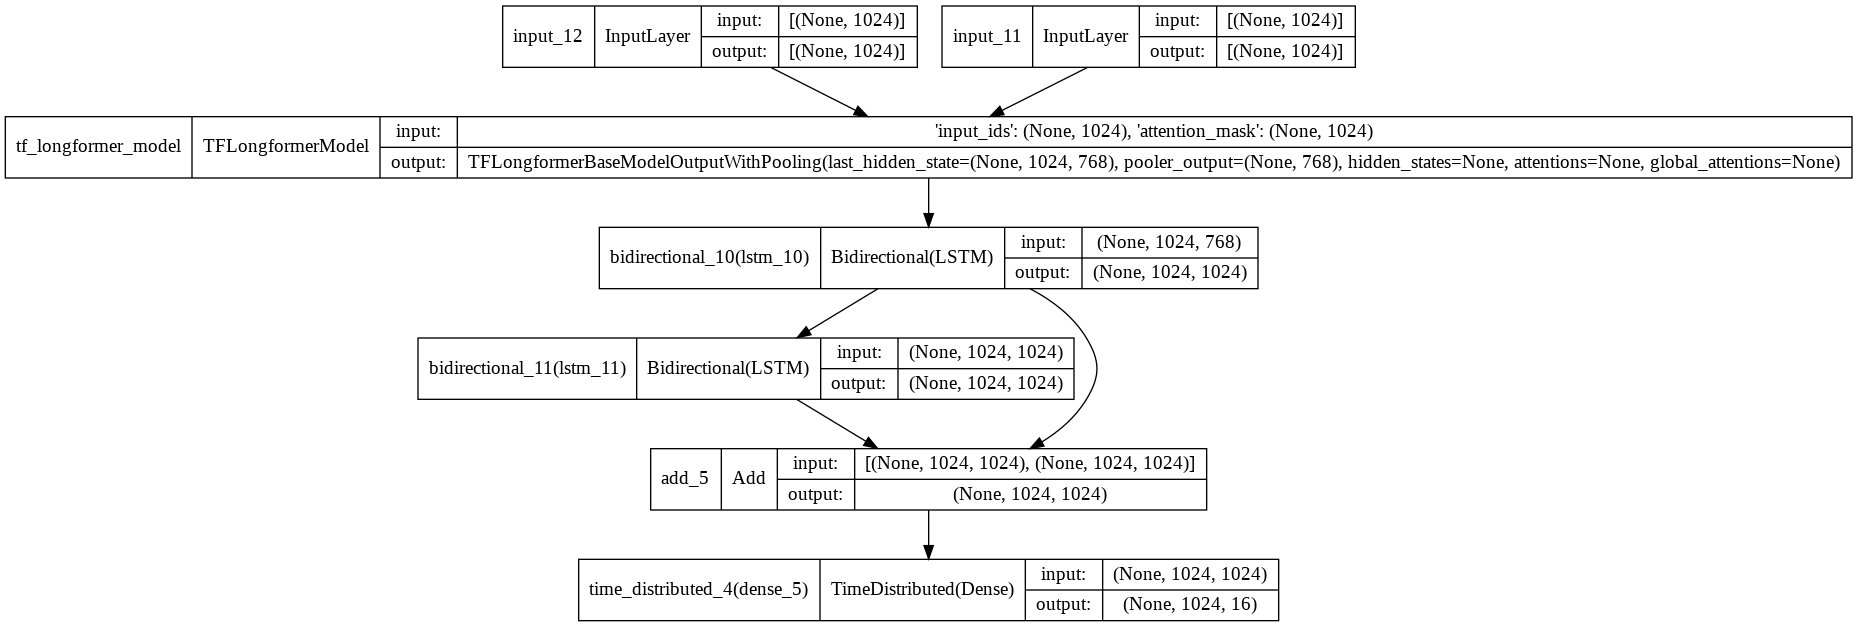

In [167]:
## instantiate the model, plot the graph
model = init_model()
tf.keras.utils.plot_model(model,show_shapes=True)

In [114]:
## show summary of model
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 1024)]       0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 1024)]       0           []                               
                                                                                                  
 tf_longformer_model (TFLongfor  TFLongformerBaseMod  148659456  ['input_8[0][0]',                
 merModel)                      elOutputWithPooling               'input_7[0][0]']                
                                (last_hidden_state=                                               
                                (None, 1024, 768),                                          

## Metrics and callbacks

In [168]:
# creating homemade metric

def accuracy_masked_func(y_true,y_pred):
    y_pred = tf.cast(tf.argmax(y_pred,axis=-1),'int32')
    y_true = tf.cast(y_true,'int32')
    y_true = tf.cast(tf.argmax(y_true,axis=-1),'int32') #for y_pred and y_true to match
    mask = tf.cast(y_true != 15,'int32') #create a mask
    matches = tf.cast(tf.equal(y_true,y_pred),'int32')*mask #calculate the matches ignoring the masking
    accuracy = tf.math.reduce_sum(matches,axis=-1)/tf.maximum(tf.math.reduce_sum(mask,axis=-1),1)
    
    return accuracy



In [174]:
#### CALLBACKS

checkpoints_path = '/content/drive/MyDrive/feedback-prize/checkpoints/fulltraining_lstm_0402.ckpt'
logdir = '/content/drive/MyDrive/feedback-prize/logs/'


#early stopping
es = tf.keras.callbacks.EarlyStopping(patience=1,restore_best_weights=True)

#save weights at every epoch
checkpoint_saver = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoints_path,
                                                      save_weights_only=True,
                                                      save_best_only = True,
                                                      monitor = 'val_categorical_accuracy',
                                                      mode = 'max',
                                                      verbose = 1)

#logs for tensorboard
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=logdir)

# list callbacks

callbacks=[es,checkpoint_saver,tensorboard]

In [175]:
## compile the model 

loss = tf.keras.losses.CategoricalCrossentropy(name='categorical_crossentropy')
cat_accuracy = tf.keras.metrics.CategoricalAccuracy()
masked_accuracy = tf.keras.metrics.MeanMetricWrapper(fn=accuracy_masked_func)

opt = tf.keras.optimizers.RMSprop(clipvalue=.5,learning_rate=0.0001)
# opt = tf.keras.optimizers.Adam(clipvalue=.5)

model.compile(optimizer=opt,loss=loss,metrics=[cat_accuracy,masked_accuracy])

## Training

In [176]:
#### ADD CELL TO LOAD WEIGHTS IF TRAINED

In [177]:
## TRAINING
history = model.fit(train[0],train[1],
                    validation_data= (val[0],val[1]),
                    epochs=30,callbacks=callbacks,batch_size=16)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/30
780/780 [==============================] - ETA: 0s - loss: 0.5098 - categorical_accuracy: 0.8379 - mean_metric_wrapper_37: 0.6518
Epoch 00001: val_categorical_accuracy improved from -inf to 0.85788, saving model to /content/drive/MyDrive/feedback-prize/checkpoints/fulltraining_lstm_0402.ckpt
780/780 [==============================] - 2058s 3s/step - loss: 0.5098 - categorical_accuracy: 0.8379 - mean_metric_wrapper_37: 0.6518 - val_loss: 0.4350 - val_categorical_accuracy: 0.8579 - val_mean_metric_wrapper_37: 0.6752
Epoch 2/30
780/780 [==============================] - ETA: 0s - loss: 0.3917 - categorical_accuracy: 0.8744 - mean_metric_wrapper_37: 0.7168
Epoch 00002: val_categorical_accuracy improved from 0.85788 to 0.87766, saving model to /content/drive/MyDrive/feedback-prize/checkpoints/fulltraining_lstm_0402.ckpt
780/780 [==============================] - 1973s 3s/step - loss: 0.3917 - categorical_accuracy: 0.8744 - mean_metric_wrapper_37: 0.7168 - val_loss: 0.3822 - val_c

In [ ]:
model.save_weights('/content/drive/MyDrive/feedback-prize/fulltraining_lstm/mymodel_lstm')